In [27]:
# Imports

import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score

In [28]:
# Import the data

df = pd.read_csv('Data/everything.csv')

df = df.replace({'^a2:56:2d:..:..:..$': 'a2:56:2d:00:00:01'}, regex=True)
df = df.replace({'^1c:57:dc:..:..:..$': '1c:57:dc:00:00:02'}, regex=True)
df = df.replace({'^36:bb:e4:..:..:..$': '36:bb:e4:00:00:03'}, regex=True)
df = df.replace({'^1c:57:dc:..:..:..$': '1c:57:dc:00:00:04'}, regex=True)
df = df.replace({'^80:da:c2:..:..:..$': '80:da:c2:00:00:05'}, regex=True)


# For privacy reasons I have altered the MAC addresses of the devices since they are unique. But I have left their
# identifiers.
# I have also not shared the cvs file with all the data.
# I have left the outputs, do not reload the page if you don't want to lose them.

In [29]:
df.tail()

,No.,Time,Source,Destination,Protocol,Length,Receiver address,Source address,Info
760648,8885327,50572.771263,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...
760649,8885330,50572.771348,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...
760650,8885451,50576.662525,ap-guc3.spotify.com,MacBook-Air-4.local,TCP,113,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP ACKed unseen segment] tripe(4070) > 538...
760651,8885456,50576.662637,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...
760652,8885690,50586.391013,clientstream-ga.launchdarkly.com,MacBook-Air-4.local,TCP,1550,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53888 [ACK...


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760653 entries, 0 to 760652
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   No.               760653 non-null  int64  
 1   Time              760653 non-null  float64
 2   Source            760653 non-null  object 
 3   Destination       760653 non-null  object 
 4   Protocol          760653 non-null  object 
 5   Length            760653 non-null  int64  
 6   Receiver address  760653 non-null  object 
 7   Source address    760653 non-null  object 
 8   Info              760648 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 52.2+ MB


In [4]:
# Either the Source or the Destination must be one of 4 devices.
# First we will determine the naming scheme for those 4 devices.

first_iPhone = 'a2:56:2d:00:00:01'
first_Mac = '1c:57:dc:00:00:02'
second_iPhone = '36:bb:e4:00:00:03'
second_Mac = '1c:57:dc:00:00:04'

person1 = [first_iPhone, first_Mac]
person2 = [second_iPhone, second_Mac]

targets =[first_iPhone, first_Mac, second_iPhone, second_Mac]

In [5]:
# Filter all the network data so we only look at traffic from our targets

df = df[df['Receiver address'].isin(targets) | df['Source address'].isin(targets)]

# Filter connections where the targets are sending data between themselves

filter_df = df[df['Receiver address'].isin(targets)]
filter_df = filter_df[filter_df['Source address'].isin(targets)]
df = df[-df['No.'].isin(filter_df['No.'])]

df.tail()

,No.,Time,Source,Destination,Protocol,Length,Receiver address,Source address,Info
760648,8885327,50572.771263,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...
760649,8885330,50572.771348,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...
760650,8885451,50576.662525,ap-guc3.spotify.com,MacBook-Air-4.local,TCP,113,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP ACKed unseen segment] tripe(4070) > 538...
760651,8885456,50576.662637,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...
760652,8885690,50586.391013,clientstream-ga.launchdarkly.com,MacBook-Air-4.local,TCP,1550,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53888 [ACK...


In [6]:
# We'll create 2 new columns
# The first ill be the Who column. This can either be Person1 or Person2

df.loc[df['Source address'].isin(person1), 'Person'] = 'Person1'
df.loc[df['Receiver address'].isin(person1), 'Person'] = 'Person1'
df.loc[df['Source address'].isin(person2), 'Person'] = 'Person2'
df.loc[df['Receiver address'].isin(person2), 'Person'] = 'Person2'


df.tail()

,No.,Time,Source,Destination,Protocol,Length,Receiver address,Source address,Info,Person
760648,8885327,50572.771263,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...,Person2
760649,8885330,50572.771348,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...,Person2
760650,8885451,50576.662525,ap-guc3.spotify.com,MacBook-Air-4.local,TCP,113,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP ACKed unseen segment] tripe(4070) > 538...,Person2
760651,8885456,50576.662637,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...,Person2
760652,8885690,50586.391013,clientstream-ga.launchdarkly.com,MacBook-Air-4.local,TCP,1550,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53888 [ACK...,Person2


In [7]:
# The connections are split between destination and source columns and polluted with 
# different values for our two people's devices. Here we capture them all and add them to a
# new column called 'domain'


df.loc[df['Source address'].isin(targets), 'Domain'] = df['Destination']
df.loc[df['Receiver address'].isin(targets), 'Domain'] = df['Source']

df.tail()


,No.,Time,Source,Destination,Protocol,Length,Receiver address,Source address,Info,Person,Domain
760648,8885327,50572.771263,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...,Person2,wss-primary.slack.com
760649,8885330,50572.771348,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...,Person2,wss-primary.slack.com
760650,8885451,50576.662525,ap-guc3.spotify.com,MacBook-Air-4.local,TCP,113,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP ACKed unseen segment] tripe(4070) > 538...,Person2,ap-guc3.spotify.com
760651,8885456,50576.662637,wss-primary.slack.com,MacBook-Air-4.local,TCP,1169,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53851 [PSH...,Person2,wss-primary.slack.com
760652,8885690,50586.391013,clientstream-ga.launchdarkly.com,MacBook-Air-4.local,TCP,1550,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Retransmission] https(443) > 53888 [ACK...,Person2,clientstream-ga.launchdarkly.com


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 657874 entries, 0 to 760652
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   No.               657874 non-null  int64  
 1   Time              657874 non-null  float64
 2   Source            657874 non-null  object 
 3   Destination       657874 non-null  object 
 4   Protocol          657874 non-null  object 
 5   Length            657874 non-null  int64  
 6   Receiver address  657874 non-null  object 
 7   Source address    657874 non-null  object 
 8   Info              657872 non-null  object 
 9   Person            657874 non-null  object 
 10  Domain            657874 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 76.4+ MB


In [9]:
# There are a lot of domains, these need to be categorized then turned into
# One-Hot-Encoded columns.

#print(1-(len(options)/len(df['Domain']))*100)
# 87% of the data can immediatly be collapsed into ~800 urls which is great
# we should be able to collapse it even futher


options = df["Domain"]

domain_filter = {
    "facebook":["instagram", "fbcdn", "facebook"],
    "apple":["apple", "itunes"],
    "akamai":["akamai"],
    "cloudfront":["cloudfront"],
    "spotify":["spotify"],
    "google":["google", "gmail"],
    "amazon":["amazo"],
    "spotify":["spotify"],
    "github":["git"],
    "1e100":["1e100"],
    "duolingo":["duolingo"],
    "chase":["chase"],
    "whatsapp":["whatsapp"],
    "slack":["slack"]
                }

for key, values in domain_filter.items():
    for value in values:
        df.loc[df['Domain'].str.contains(value), 'Domain'] = key



In [10]:
count = df.Domain.value_counts().sort_index(ascending=False).to_frame()
count.head()

,Domain
zpns-byoip-va.zoom.us,200
zoom.us,464
www.gstatic.com,12
www.figma.com,6026
whatsapp,351


<AxesSubplot: xlabel='Domain'>

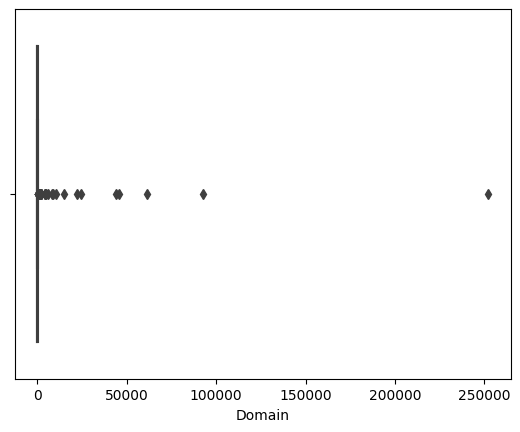

In [11]:
sns.boxplot(x=count["Domain"])

<AxesSubplot: xlabel='Domain'>

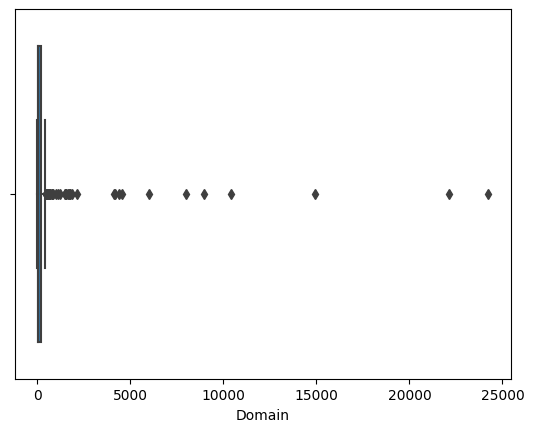

In [12]:
# Remove outliers past 2 standard deviations

count[
        (count['Domain'] > count['Domain'].mean() + 2*count['Domain'].std()) 
        | (count['Domain'] < count['Domain'].mean()-2*count['Domain'].std()) 
    ] = np.nan

sns.boxplot(x=count["Domain"])

In [13]:
# This is a much nicer boxplot, we'll apply this same filter to our main df

count.head()

,Domain
zpns-byoip-va.zoom.us,200.0
zoom.us,464.0
www.gstatic.com,12.0
www.figma.com,6026.0
whatsapp,351.0


In [14]:
count.dropna().head()

,Domain
zpns-byoip-va.zoom.us,200.0
zoom.us,464.0
www.gstatic.com,12.0
www.figma.com,6026.0
whatsapp,351.0


In [15]:
df = df[df['Domain'].isin(count.dropna().index)]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162220 entries, 5 to 760652
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   No.               162220 non-null  int64  
 1   Time              162220 non-null  float64
 2   Source            162220 non-null  object 
 3   Destination       162220 non-null  object 
 4   Protocol          162220 non-null  object 
 5   Length            162220 non-null  int64  
 6   Receiver address  162220 non-null  object 
 7   Source address    162220 non-null  object 
 8   Info              162220 non-null  object 
 9   Person            162220 non-null  object 
 10  Domain            162220 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 14.9+ MB


In [17]:
df.head()

,No.,Time,Source,Destination,Protocol,Length,Receiver address,Source address,Info,Person,Domain
5,2195,8.854009,wss-primary.slack.com,MacBook-Air-4.local,TCP,102,1c:57:dc:00:00:04,80:da:c2:00:00:05,https(443) > 58176 [ACK] Seq=1 Ack=1 Win=8 L...,Person2,slack
6,2205,8.857885,wss-primary.slack.com,MacBook-Air-4.local,TCP,102,1c:57:dc:00:00:04,80:da:c2:00:00:05,[TCP Dup ACK 2195#1] https(443) > 58176 [ACK...,Person2,slack
8,2461,8.926175,http2.slack.map.fastly.net,MacBook-Air-4.local,TCP,96,1c:57:dc:00:00:04,80:da:c2:00:00:05,https(443) > 58180 [RST] Seq=1 Win=0 Len=0,Person2,slack
11,2730,9.042042,etsy.map.fastly.net,MacBook-Air-4.local,TCP,102,1c:57:dc:00:00:04,80:da:c2:00:00:05,https(443) > 58203 [ACK] Seq=1 Ack=1 Win=285...,Person2,etsy.map.fastly.net
13,3074,9.166274,etsy.map.fastly.net,MacBook-Air-4.local,TLSv1.2,1546,1c:57:dc:00:00:04,80:da:c2:00:00:05,Ignored Unknown Record,Person2,etsy.map.fastly.net


In [18]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    return(res)

In [19]:
df = encode_and_bind(df, 'Domain')

In [20]:
# Let's drop useless and redudant columns
df = df.drop(columns=['No.', 'Time', 'Protocol', 'Source', 'Destination', 'Receiver address', 'Source address', 'Info', 'Domain'])
df.head()

,Length,Person,Domain_104.18.43.48,Domain_104.19.152.69,Domain_104.244.42.194,Domain_104.244.42.197,Domain_104.244.42.212,Domain_104.244.42.65,Domain_104.244.43.131,Domain_138.128.247.123,...,Domain_us01xmppapi-ngxsvr7.zoom.us,Domain_uschi5-vip-bx-003.aaplimg.com,Domain_usdal4-vip-bx-004.b.aaplimg.com,Domain_usnyc3-vip-bx-002.a.aaplimg.com,Domain_usrtv2-vip-bx-001.aaplimg.com,Domain_whatsapp,Domain_www.figma.com,Domain_www.gstatic.com,Domain_zoom.us,Domain_zpns-byoip-va.zoom.us
5,102,Person2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,102,Person2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,96,Person2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,102,Person2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,1546,Person2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# The initial data preparation is complete! Let's build our model now.

In [22]:
scaled_df = df.copy()

In [23]:
scaled_df = scaled_df.drop('Person',axis=1)
columns = scaled_df.columns.values.tolist()
scaled = StandardScaler()
scaled.fit(scaled_df[columns])
inputs_scaled = scaler.transform(scaled_df[columns])
scaled_df = pd.DataFrame(inputs_scaled,columns=columns)

scaled_df.head()

,Length,Domain_104.18.43.48,Domain_104.19.152.69,Domain_104.244.42.194,Domain_104.244.42.197,Domain_104.244.42.212,Domain_104.244.42.65,Domain_104.244.43.131,Domain_138.128.247.123,Domain_140.82.112.25,...,Domain_us01xmppapi-ngxsvr7.zoom.us,Domain_uschi5-vip-bx-003.aaplimg.com,Domain_usdal4-vip-bx-004.b.aaplimg.com,Domain_usnyc3-vip-bx-002.a.aaplimg.com,Domain_usrtv2-vip-bx-001.aaplimg.com,Domain_whatsapp,Domain_www.figma.com,Domain_www.gstatic.com,Domain_zoom.us,Domain_zpns-byoip-va.zoom.us
0,-0.950149,-0.014264,-0.0043,-0.0043,-0.007449,-0.017382,-0.020925,-0.017559,-0.007449,-0.0159,...,-0.018416,-0.097835,-0.030321,-0.048775,-0.016093,-0.046566,-0.196419,-0.008601,-0.053559,-0.035134
1,-0.950149,-0.014264,-0.0043,-0.0043,-0.007449,-0.017382,-0.020925,-0.017559,-0.007449,-0.0159,...,-0.018416,-0.097835,-0.030321,-0.048775,-0.016093,-0.046566,-0.196419,-0.008601,-0.053559,-0.035134
2,-0.959603,-0.014264,-0.0043,-0.0043,-0.007449,-0.017382,-0.020925,-0.017559,-0.007449,-0.0159,...,-0.018416,-0.097835,-0.030321,-0.048775,-0.016093,-0.046566,-0.196419,-0.008601,-0.053559,-0.035134
3,-0.950149,-0.014264,-0.0043,-0.0043,-0.007449,-0.017382,-0.020925,-0.017559,-0.007449,-0.0159,...,-0.018416,-0.097835,-0.030321,-0.048775,-0.016093,-0.046566,-0.196419,-0.008601,-0.053559,-0.035134
4,1.325014,-0.014264,-0.0043,-0.0043,-0.007449,-0.017382,-0.020925,-0.017559,-0.007449,-0.0159,...,-0.018416,-0.097835,-0.030321,-0.048775,-0.016093,-0.046566,-0.196419,-0.008601,-0.053559,-0.035134


In [24]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, df['Person'])

In [25]:
svc_params = {'svc__kernel': ['sigmoid', 'rbf', 'linear']
              'svc__gamma': [0.1, 1.0, 10.0]
              'svc__coef0':[0, 1, 2]
             }

svc_pipe = Pipeline([('scale', StandardScaler()), ('svc', SVC())])
svc_grid = GridSearchCV(svc_pipe, param_grid=svc_params)

svc = svc_grid.fit(X_train, y_train)

In [26]:
svc_train_score = accuracy_score(svc.predict(X_train), y_train)
svc_test_score = accuracy_score(svc.predict(X_test), y_test)
svc_best_params = svc.best_params_

print(svc_train_score)
print(svc_test_score)
print(svc_best_params)

0.9500184934040192
0.9516459129577117
{'svc__coef0': 0, 'svc__gamma': 0.1, 'svc__kernel': 'sigmoid'}
